In [10]:


from google.colab import drive
drive.mount('/content/drive')

# Path to your uploaded filing
html_path = "/content/drive/MyDrive/sec_filings/tsla-20250630.html"

# Where to persist the Chroma vector DB
chroma_dir = "/content/drive/MyDrive/sec_filings/chroma_db"

# Set your Google Gemini API key
os.environ["GOOGLE_API_KEY"] = "YOUR KEY"



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Characters in cleaned text: 138182
Preview:
 tsla-20250630
0001318605
12-31
false
2025
http://fasb.org/us-gaap/2025#AccountingStandardsUpdate202308Member
283
xbrli:shares
iso4217:USD
iso4217:USD
xbrli:shares
tsla:unit
xbrli:pure
tsla:Customer
tsla:Segment
0001318605
2025-01-01
2025-06-30
0001318605
2025-07-17
0001318605
2025-06-30
0001318605
2024-12-31
0001318605
tsla:OperatingLeaseVehiclesMember
2025-06-30
0001318605
tsla:OperatingLeaseVehiclesMember
2024-12-31
0001318605
tsla:SolarEnergySystemsMember
2025-06-30
0001318605
tsla:SolarEnergySystemsMember
2024-12-31
0001318605
tsla:AutomotiveSalesMember
2025-04-01
2025-06-30
0001318605
tsla:AutomotiveSalesMember
2024-04-01
2024-06-30
0001318605
tsla:AutomotiveSalesMember
2025-01-01
2025-06-30
0001318605
tsla:AutomotiveSalesMember
2024-01-01
2024-06-30
0001318605
tsla:AutomotiveRegulato
Total chunks: 150


/tmp/ipython-input-4242333682.py:54: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  vectorstore.persist()


Chroma persisted at: /content/drive/MyDrive/sec_filings/chroma_db
Using Gemini model: gemini-2.0-flash


/tmp/ipython-input-4242333682.py:89: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  resp = qa({"query": question})


Q: Summarize Tesla’s revenue and profitability highlights from this 10-Q. 

A: For the three months ended June 30, 2025, Tesla's automotive sales were $15,787 million, compared to $18,530 million for the three months ended June 30, 2024. For the six months ended June 30, 2025, automotive sales were $28,712 million, compared to $34,990 million for the six months ended June 30, 2024. The document does not contain any information regarding Tesla's profitability. 

Sources:
1. Total current liabilities 30,008 28,821 Debt and finance leases, net of current portion 5,180 5,757 Deferred revenue, net of current portion 3,764 3,317 Other long-term liabilities 11,543 10,495 Total liabilities 50,495 48,390 Commitments and contingencies (Note 10) Redeemable noncontrolling interes...
2. Total current liabilities 30,008 28,821 Debt and finance leases, net of current portion 5,180 5,757 Deferred revenue, net of current portion 3,764 3,317 Other long-term liabilities 11,543 10,495 Total liabilities 50

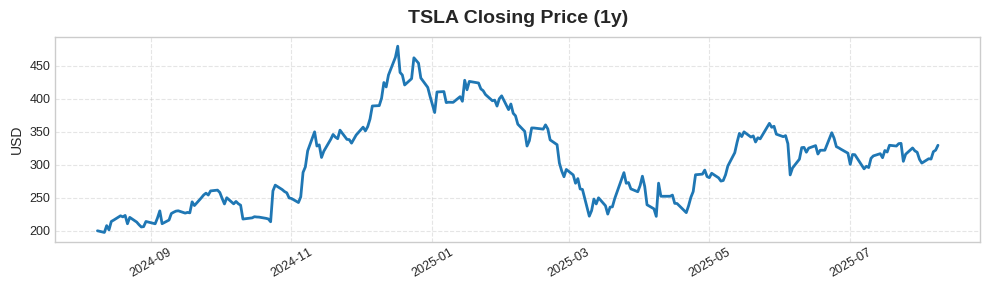

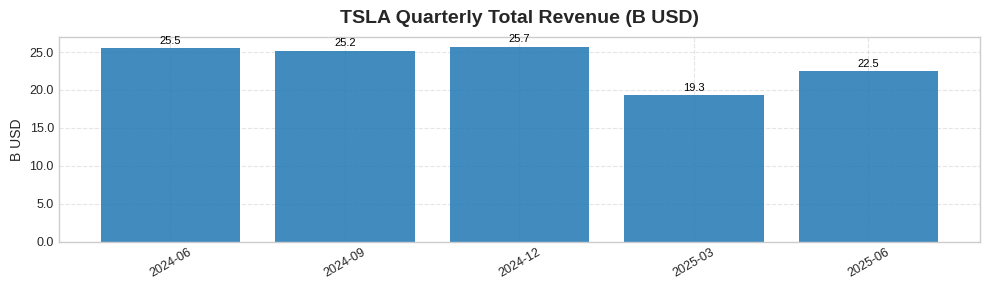

Q: From the 10-Q, summarize Tesla’s cost drivers impacting gross margin. 

A: Based on the provided context, here's a summary of Tesla's cost drivers impacting gross margin:

*   **Loss of tax credits and carbon offset mechanisms:** This negatively impacts financial results.
*   **Government and economic incentives favoring domestic manufacturers:** Incentives that benefit manufacturers who assemble domestically or have local suppliers (characteristics that may not apply to Tesla) could negatively impact demand and may require pricing modifications. 

Sources:
1. and harm our growth, prospects and operating results, and the loss of previously available tax credits and carbon offset mechanisms may further negatively impact our financial results. In addition, certain government and economic incentives may also be implemented or amended to provide benefits to m...
2. and harm our growth, prospects and operating results, and the loss of previously available tax credits and carbon offset me

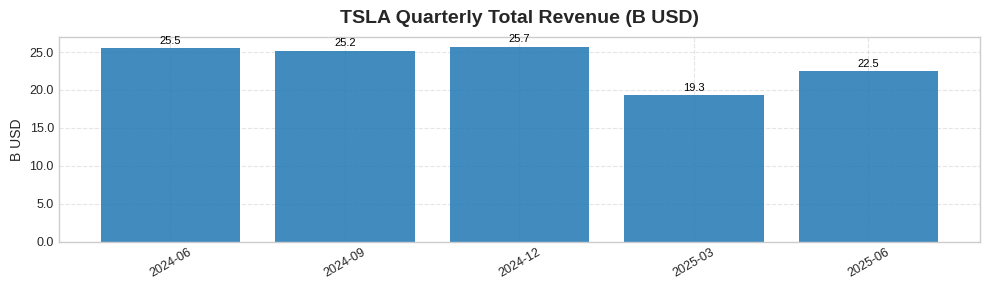

In [1]:
# ============================================
# 1) Install dependencies
# ============================================
!pip install -U langchain langchain-community langchain-google-genai chromadb beautifulsoup4 yfinance matplotlib pandas tiktoken

# ============================================
# 2) Imports, mount Drive, set paths & keys
# ============================================
import os, re
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

from google.colab import drive
drive.mount('/content/drive')

HTML_PATH = "/content/drive/MyDrive/sec_filings/tsla-20250630.html"
CHROMA_DIR = "/content/drive/MyDrive/sec_filings/chroma_db"

os.environ["GOOGLE_API_KEY"] = "YOUR KEY"
assert os.environ.get("GOOGLE_API_KEY"), "Set GOOGLE_API_KEY first."

# ============================================
# 3) Load and clean HTML -> plain text
# ============================================
def load_clean_html(path: str) -> str:
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        html = f.read()
    soup = BeautifulSoup(html, "html.parser")
    for tag in soup(["script", "style", "noscript"]):
        tag.decompose()
    text = soup.get_text(separator="\n")
    lines = [re.sub(r"\s+", " ", ln).strip() for ln in text.splitlines()]
    lines = [ln for ln in lines if len(ln) > 2]
    return "\n".join(lines)

filing_text = load_clean_html(HTML_PATH)
print("Characters in cleaned text:", len(filing_text))
print("Preview:\n", filing_text[:800])

# ============================================
# 4) Chunk, embed with Gemini, persist to Chroma
# ============================================
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_community.vectorstores import Chroma

splitter = RecursiveCharacterTextSplitter(chunk_size=1200, chunk_overlap=200)
docs = splitter.create_documents([filing_text])
print("Total chunks:", len(docs))

embeddings = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004")
vectorstore = Chroma.from_documents(docs, embedding=embeddings, persist_directory=CHROMA_DIR)
vectorstore.persist()
print("Chroma persisted at:", CHROMA_DIR)

# ============================================
# 5) Build RAG Q&A (Gemini Flash) + helper
# ============================================
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.chains import RetrievalQA

retriever = vectorstore.as_retriever(search_kwargs={"k": 4})

CANDIDATE_FLASH_MODELS = ["gemini-2.0-flash", "gemini-2.0-flash-lite", "gemini-1.5-flash"]
def make_flash_llm(temperature=0):
    last_err = None
    for m in CANDIDATE_FLASH_MODELS:
        try:
            llm = ChatGoogleGenerativeAI(model=m, temperature=temperature)
            _ = llm.invoke("ok")
            print(f"Using Gemini model: {m}")
            return llm
        except Exception as e:
            last_err = e
            continue
    raise RuntimeError(f"No Flash model accessible. Last error: {last_err}")

llm = make_flash_llm(temperature=0)

qa = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=retriever,
    chain_type="stuff",
    return_source_documents=True
)

def ask(question: str, show_sources: bool = True):
    resp = qa({"query": question})
    print("Q:", question, "\n")
    print("A:", resp["result"], "\n")
    if show_sources:
        print("Sources:")
        for i, d in enumerate(resp["source_documents"], start=1):
            snippet = d.page_content[:300].replace("\n", " ")
            print(f"{i}. {snippet}...")
    return resp

# ============================================
# 6) Smoke test
# ============================================
_ = ask("Summarize Tesla’s revenue and profitability highlights from this 10-Q.")

# ============================================
# 7) Yahoo Finance + slim blue charts
# ============================================
import yfinance as yf
import matplotlib.ticker as mtick
plt.style.use("seaborn-v0_8-whitegrid")

def get_price_history(ticker="TSLA", period="1y", interval="1d"):
    t = yf.Ticker(ticker)
    hist = t.history(period=period, interval=interval)
    if hist.empty:
        raise ValueError(f"No price data for {ticker}.")
    return hist

def plot_close_price_slim(ticker="TSLA", period="1y", interval="1d", title=None):
    df = get_price_history(ticker, period, interval)
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.plot(df.index, df["Close"], linewidth=2, color="#1f77b4")
    ax.set_title(title or f"{ticker} Closing Price ({period})", fontsize=14, weight="bold", pad=10)
    ax.set_xlabel("")
    ax.set_ylabel("USD", fontsize=10)
    ax.tick_params(axis="y", labelsize=9)
    ax.tick_params(axis="x", labelsize=9, rotation=30)
    ax.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

def plot_quarterly_revenue_slim(ticker="TSLA"):
    t = yf.Ticker(ticker)
    qfin = t.quarterly_financials
    if qfin is None or qfin.empty:
        print(f"No quarterly financials for {ticker}.")
        return
    for key in ["Total Revenue", "TotalRevenue", "Revenue"]:
        if key in qfin.index:
            rev = qfin.loc[key].sort_index()
            break
    else:
        print("No revenue key found.")
        return

    quarters = [d.strftime("%Y-%m") for d in rev.index]
    fig, ax = plt.subplots(figsize=(10, 3))
    bars = ax.bar(quarters, rev.values / 1e9, color="#1f77b4", alpha=0.85)
    ax.set_title(f"{ticker} Quarterly {key} (B USD)", fontsize=14, weight="bold", pad=10)
    ax.set_xlabel("")
    ax.set_ylabel("B USD", fontsize=10)
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter("%.1f"))
    ax.tick_params(axis="x", labelsize=9, rotation=30)
    ax.tick_params(axis="y", labelsize=9)
    ax.grid(True, linestyle="--", alpha=0.5)
    for b in bars:
        h = b.get_height()
        ax.annotate(f"{h:.1f}", (b.get_x()+b.get_width()/2, h), textcoords="offset points",
                    xytext=(0,3), ha="center", fontsize=8, color="black")
    plt.tight_layout()
    plt.show()

# Examples
plot_close_price_slim("TSLA", period="1y")
plot_quarterly_revenue_slim("TSLA")

# ============================================
# 8) Combined helper
# ============================================
def ask_with_chart(q, ticker=None, chart=None):
    resp = ask(q)
    if ticker and chart:
        if chart.lower() == "close":
            plot_close_price_slim(ticker, period="1y")
        elif chart.lower() == "revenue":
            plot_quarterly_revenue_slim(ticker)
    return resp

# Example
_ = ask_with_chart("From the 10-Q, summarize Tesla’s cost drivers impacting gross margin.", ticker="TSLA", chart="revenue")
